# Game of Clones

## Telling the rival Game of Thrones subreddits apart

Can Natural Language Processing combined with predictive models accurately distinguish between posts on <a href='https://www.reddit.com/r/pureasoiaf/'>`r/pureasoiaf/`</a> and <a href='https://www.reddit.com/r/freefolk/'>`r/freefolk/`</a>?

### ...Game of what? (Skip if you are familiar with GOT)

Game of Thrones, as in the multi-season, award-winning, fantasy <a href='https://www.hbo.com/game-of-thrones'>HBO series</a> based on the "A Song of Ice and Fire" novels by <a href='http://www.georgerrmartin.com'>George R. R. Martin</a>. Over 73 episodes of clashing armies, medieval politics, and fire-spewing dragons, noble houses with generations of enmity duke it out for the right to sit on the iron throne - the metaphorical and literal seat of power. Meanwhile, a large band of so-called Wildlings live outside the jurisdiction of the warring kingdoms, where the self-proclaimed freefolk contend with an ancient evil that will eventually threaten the existence of all living beings...  

### OK, what have we got?

Right, back to your regular programming. We will look at two subreddits dedicated to the TV series and books. <a href='https://www.reddit.com/r/pureasoiaf/'>`r/pureasoiaf/`</a> (a.k.a. Pure A Song of Ice and Fire) is dedicated solely to the novels and "does not allow content from the popular HBO series. Game of Thrones". As the TV series' plot development has overtaken that of the books and revealed the story's conclusion, book fans in `pureasoiaf` are exacting in ensuring they aren't contaminated by spoilers from the outside world. 

<a href='https://www.reddit.com/r/freefolk/'>`r/freefolk/`</a> live outside the jurisdiction of spoiler rules and declares that "we believe people are mature enough to decide for themselves what content to view".

### Goal

Let's see if a machine can identify the purists among the wider fan community. 

### Contents:
- [Data gathering from subreddits](#Data-gathering-from-subreddits)
- [Data cleaning and exploration](#Data-cleaning-and-exploration)
- [Modelling](#Modelling)
- [Logistic model analysis](#Logistic-model-analysis)
- [Conclusion](#Conclusion)

*All libraries used are added here*

In [1]:
#Imports:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)
sns.set_style("whitegrid")

import requests
import time
import string

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

## Data gathering from subreddits

### Use Reddit API to gather posts

#### Gather posts from `freefolk`

In [2]:
headers={'User-agent':'Peter Parker far from home'}#set header to prevent 429 status code

free_posts=[] #for storing of posts
after=None #so that param to be empty for the first iteration
for num in range(40): #range number will indicate how many pages of 25 posts to scrape
    if num % 10 == 0: #print whenever we are at 10th page
        print(num) #just to keep track that kernel is still runnning and how many pages we are at
    if after == None:
        param={} 
    else:
        param={'after':after}
    url = 'https://www.reddit.com/r/freefolk/.json'
    results = requests.get(url,params=param,headers=headers)
    if results.status_code==200: #to check if request successful
        d_json=results.json()
        free_posts.extend(d_json['data']['children']) 
        after=d_json['data']['after'] #so that after no longer == None and param={'after':after"} triggered 
    else:
        print(results.status_code)
        break
    time.sleep(1) #seconds to sleep

0
10
20
30


In [3]:
len(free_posts)

992

In [4]:
#check if posts are unique
len(set([post['data']['name'] for post in free_posts]))

992

We have 992 unique posts from `freefolk`.

In [5]:
#checking keys of each post
free_posts[0]['data'].keys()

dict_keys(['approved_at_utc', 'subreddit', 'selftext', 'author_fullname', 'saved', 'mod_reason_title', 'gilded', 'clicked', 'title', 'link_flair_richtext', 'subreddit_name_prefixed', 'hidden', 'pwls', 'link_flair_css_class', 'downs', 'thumbnail_height', 'hide_score', 'name', 'quarantine', 'link_flair_text_color', 'author_flair_background_color', 'subreddit_type', 'ups', 'total_awards_received', 'media_embed', 'thumbnail_width', 'author_flair_template_id', 'is_original_content', 'user_reports', 'secure_media', 'is_reddit_media_domain', 'is_meta', 'category', 'secure_media_embed', 'link_flair_text', 'can_mod_post', 'score', 'approved_by', 'thumbnail', 'edited', 'author_flair_css_class', 'author_flair_richtext', 'gildings', 'content_categories', 'is_self', 'mod_note', 'created', 'link_flair_type', 'wls', 'banned_by', 'author_flair_type', 'domain', 'allow_live_comments', 'selftext_html', 'likes', 'suggested_sort', 'banned_at_utc', 'view_count', 'archived', 'no_follow', 'is_crosspostable', 

In [6]:
free_df = pd.DataFrame([post['data'] for post in free_posts])
free_df.head()

,all_awardings,allow_live_comments,approved_at_utc,approved_by,archived,author,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,author_flair_text_color,author_flair_type,author_fullname,author_patreon_flair,banned_at_utc,banned_by,can_gild,can_mod_post,category,clicked,content_categories,contest_mode,created,created_utc,crosspost_parent,crosspost_parent_list,discussion_type,distinguished,domain,downs,edited,gilded,gildings,hidden,hide_score,id,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,likes,link_flair_background_color,link_flair_css_class,link_flair_richtext,link_flair_template_id,link_flair_text,...,media,media_embed,media_metadata,media_only,mod_note,mod_reason_by,mod_reason_title,mod_reports,name,no_follow,num_comments,num_crossposts,num_reports,over_18,parent_whitelist_status,permalink,pinned,post_hint,preview,pwls,quarantine,removal_reason,report_reasons,saved,score,secure_media,secure_media_embed,selftext,selftext_html,send_replies,spoiler,stickied,subreddit,subreddit_id,subreddit_name_prefixed,subreddit_subscribers,subreddit_type,suggested_sort,thumbnail,thumbnail_height,thumbnail_width,title,total_awards_received,ups,url,user_reports,view_count,visited,whitelist_status,wls
0,[],True,None,None,False,Im-not-Steve,None,None,[],None,None,None,text,t2_c54kv,False,None,None,False,False,None,False,None,False,1.563607e+09,1.563579e+09,NaN,NaN,None,None,self.freefolk,0,False,0,{},False,False,cfetu0,False,False,False,False,True,True,False,None,,None,[],NaN,None,...,None,{},NaN,False,None,None,None,[],t3_cfetu0,False,656,0,None,False,all_ads,/r/freefolk/comments/cfetu0/san_diego_comic_co...,False,NaN,NaN,6,False,None,None,False,615,None,{},If anyone is there and wants to share their pi...,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",True,False,True,freefolk,t5_37tpy,r/freefolk,1105026,public,None,self,NaN,NaN,SAN DIEGO COMIC CON 2019 MEGATHREAD,0,615,https://www.reddit.com/r/freefolk/comments/cfe...,[],None,False,all_ads,6
1,[],False,None,None,False,AutoModerator,None,None,[],None,None,None,text,t2_6l4z3,False,None,None,False,False,None,False,None,False,1.563812e+09,1.563783e+09,NaN,NaN,None,moderator,self.freefolk,0,False,0,{},False,False,cgadzu,False,False,False,False,True,True,False,None,,None,[],NaN,None,...,None,{},NaN,False,None,None,None,[],t3_cgadzu,True,38,0,None,False,all_ads,/r/freefolk/comments/cgadzu/daily_rfreefolk_fr...,False,NaN,NaN,6,False,None,None,False,10,None,{},This is a daily Free Talk thread. Feel free to...,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",False,False,True,freefolk,t5_37tpy,r/freefolk,1105026,public,None,self,NaN,NaN,"Daily /r/Freefolk Free Talk Thread! - July 22,...",0,10,https://www.reddit.com/r/freefolk/comments/cga...,[],None,False,all_ads,6
2,"[{'is_enabled': True, 'count': 1, 'subreddit_i...",True,None,None,False,TheCrazyPurple,None,nokneeling,[],c0f4cdf8-6459-11e7-873f-0ed8b491c814,We do not kneel,dark,text,t2_pfgxt,False,None,None,False,False,None,False,None,False,1.563790e+09,1.563761e+09,NaN,NaN,None,None,self.freefolk,0,1.56377e+09,1,"{'gid_1': 3, 'gid_2': 1}",False,False,cg79ok,False,False,False,False,True,True,False,None,#8000ff,purple,[],b18bb2de-f7c0-11e5-91d8-0e1f6820d4a9,Hilarity4Charity,...,None,{},NaN,False,None,None,None,[],t3_cg79ok,False,436,3,None,False,all_ads,/r/freefolk/comments/cg79ok/seth_rogen_fought_...,False,self,{'images': [{'source': {'url': 'https://extern...,6,False,None,None,False,22980,None,{},https://hilarityforcharity.org/\n\nThe Freefol...,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",True,False,False,freefolk,t5_37tpy,r/freefolk,1105026,public,None,self,NaN,NaN,"Seth Rogen fought for us, will you fight for h...",7,22980,https://www.reddit.com/r/freefolk/comments/cg7...,[],None,False,all_ads,6
3,[],False,None,None,False,SS2602,None,jon-snow,[],9caaa03e-645a-11e7-b1b8-0eba0e159030,Aejon Snowarkgaryan,

#### Gather posts from `pureasoiaf`

In [7]:
headers={'User-agent':'Peter Parker far from home'}#set header to prevent 429 status code

pure_posts=[] #for storing of posts
after=None #so that param to be empty for the first iteration
for num in range(40): #range number will indicate how many pages of 25 posts to scrape
    if num % 10 == 0: #print whenever we are at 10th page
        print(num) #just to keep track that kernel is still runnning and how many pages we are at
    if after == None:
        param={} 
    else:
        param={'after':after}
    url = 'https://www.reddit.com/r/pureasoiaf/.json'
    results = requests.get(url,params=param,headers=headers)
    if results.status_code==200: #to check if request successful
        d_json=results.json()
        pure_posts.extend(d_json['data']['children']) 
        after=d_json['data']['after'] #so that after no longer == None and param={'after':after"} triggered 
    else:
        print(results.status_code)
        break
    time.sleep(1) #seconds to sleep

0
10
20
30


In [8]:
len(pure_posts)

985

In [9]:
len(set([post['data']['name'] for post in pure_posts]))

985

We have 985 posts from `pureasoiaf`.

In [10]:
pure_df = pd.DataFrame([post['data'] for post in pure_posts])
pure_df.head()

,all_awardings,allow_live_comments,approved_at_utc,approved_by,archived,author,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,author_flair_text_color,author_flair_type,author_fullname,author_patreon_flair,banned_at_utc,banned_by,can_gild,can_mod_post,category,clicked,content_categories,contest_mode,created,created_utc,crosspost_parent,crosspost_parent_list,discussion_type,distinguished,domain,downs,edited,gilded,gildings,hidden,hide_score,id,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,likes,link_flair_background_color,link_flair_css_class,link_flair_richtext,link_flair_template_id,link_flair_text,...,media,media_embed,media_metadata,media_only,mod_note,mod_reason_by,mod_reason_title,mod_reports,name,no_follow,num_comments,num_crossposts,num_reports,over_18,parent_whitelist_status,permalink,pinned,post_hint,preview,pwls,quarantine,removal_reason,report_reasons,saved,score,secure_media,secure_media_embed,selftext,selftext_html,send_replies,spoiler,stickied,subreddit,subreddit_id,subreddit_name_prefixed,subreddit_subscribers,subreddit_type,suggested_sort,thumbnail,thumbnail_height,thumbnail_width,title,total_awards_received,ups,url,user_reports,view_count,visited,whitelist_status,wls
0,[],True,None,None,True,JewBot6000,,s-baratheon,[],None,I am King. Wants do not enter into it.,dark,text,t2_6wj87,False,None,None,False,False,None,False,None,False,1.461533e+09,1.461504e+09,NaN,NaN,None,moderator,self.pureasoiaf,0,1.46238e+09,0,{},False,False,4g83fj,False,False,False,False,True,True,False,None,,mod,[],NaN,From the Citadel,...,None,{},NaN,False,None,None,None,[],t3_4g83fj,False,111,0,None,False,all_ads,/r/pureasoiaf/comments/4g83fj/no_spoilers_a_fa...,False,NaN,NaN,6,False,None,None,False,244,None,{},# WE DO NOT SHOW\n\nThe following is text copi...,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",True,False,True,pureasoiaf,t5_3288z,r/pureasoiaf,88679,public,None,self,NaN,NaN,[No Spoilers] A Fair Warning. (ALL USERS PLEAS...,0,244,https://www.reddit.com/r/pureasoiaf/comments/4...,[],None,False,all_ads,6
1,[],True,None,None,False,npropanol,None,None,[],None,None,None,text,t2_eymoe,False,None,None,False,False,None,False,None,False,1.563824e+09,1.563795e+09,NaN,NaN,None,None,imgur.com,0,False,0,{},False,False,cgc2aa,False,False,False,False,True,False,False,None,,adwd,[],NaN,Spoilers ADWD,...,None,{},NaN,False,None,None,None,[],t3_cgc2aa,False,20,0,None,False,all_ads,/r/pureasoiaf/comments/cgc2aa/spoilers_adwd_th...,False,link,{'images': [{'source': {'url': 'https://extern...,6,False,None,None,False,234,None,{},,None,True,True,False,pureasoiaf,t5_3288z,r/pureasoiaf,88679,public,None,spoiler,73.0,140.0,(Spoilers ADWD) This gave me all kinds of goos...,0,234,https://imgur.com/IPse78J,[],None,False,all_ads,6
2,[],False,None,None,False,vallraffs,,targ,[],None,Gown Loyalist,dark,text,t2_g81ew,False,None,None,False,False,None,False,None,False,1.563811e+09,1.563783e+09,NaN,NaN,None,None,self.pureasoiaf,0,False,0,{},False,False,cgad70,False,False,False,False,True,True,False,None,,spoilers-default,[],NaN,Spoilers Default,...,None,{},NaN,False,None,None,None,[],t3_cgad70,False,14,0,None,False,all_ads,/r/pureasoiaf/comments/cgad70/why_does_harrenh...,False,NaN,NaN,6,False,None,None,False,43,None,{},I was just thinking of [this thread](https://o...,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",True,False,False,pureasoiaf,t5_3288z,r/pureasoiaf,88679,public,None,self,NaN,NaN,Why does Harrenhal have a Weirwood?,0,43,https://www.reddit.com/r/pureasoiaf/comments/c...,[],None,False,all_ads,6
3,[],True,None,None,False,davegoestohollywood,None,None,[],None,None,None,text,t2_2vz652gx,False,None,None,False,False,None,False,None,False,1.563758e+09,1.563730e+09,NaN,NaN,None,None,self.pureasoiaf,0,1.56373e+09,0,{},False,False,cg1g6c,False,False,False,False,True,True,False,None,,spoilers-default,[],NaN,Spoilers Default,..

## Data cleaning and exploration

### Sieving relevant data 

We want the title (`title`), text within the post (`selftext`), post id (`name`), and subreddit (`subreddit`) it belongs to. 

In [348]:
free_select_df = free_df[['name','title','selftext','subreddit']]
free_select_df.head()

,name,title,selftext,subreddit
0,t3_cfetu0,SAN DIEGO COMIC CON 2019 MEGATHREAD,If anyone is there and wants to share their pics or videos let's see them! Anybody at the Con with some cool stories let's hear it!\n\n\...,freefolk
1,t3_cgadzu,"Daily /r/Freefolk Free Talk Thread! - July 22, 2019",This is a daily Free Talk thread. Feel free to discuss whatever you like!,freefolk
2,t3_cg79ok,"Seth Rogen fought for us, will you fight for him? (Info &amp; Links to Hilarity for charity - Founded by Seth and his wife Lauren)",https://hilarityforcharity.org/\n\nThe Freefolk have shown their love for Seth Rogen recently after seeing him speak out publicly and I ...,freefolk
3,t3_cgb3nt,"Kind of explains it, I guess.",,freefolk
4,t3_cg5vus,Guys I found the entire series on DVD at Target!,,freefolk


In [349]:
free_select_df.dtypes

name         object
title        object
selftext     object
subreddit    object
dtype: object

In [350]:
pure_select_df = pure_df[['name','title','selftext','subreddit']]
pure_select_df.head()

,name,title,selftext,subreddit
0,t3_4g83fj,[No Spoilers] A Fair Warning. (ALL USERS PLEASE READ BEFORE POSTING),"# WE DO NOT SHOW\n\nThe following is text copied directly from the /r/pureasoiaf rules, located in [our wiki](https://www.reddit.com/r/p...",pureasoiaf
1,t3_cgc2aa,(Spoilers ADWD) This gave me all kinds of goosebumps,,pureasoiaf
2,t3_cgad70,Why does Harrenhal have a Weirwood?,I was just thinking of [this thread](https://old.reddit.com/r/pureasoiaf/comments/c5so84/daemon_targaryen_and_arya_stood_at_the_very_sam...,pureasoiaf
3,t3_cg1g6c,Does Stevron's death threaten the stability of house Frey.,I read something about Old Walder grooming Stevron in his own philosophy of taking care of the whole extended family\n\n&gt;The old man ...,pureasoiaf
4,t3_cg21lz,Where was Tyrion before he arrived at Winterfell with Robert's Caravan?,"The text is a bit ambiguous about it.Was he staying in the Red Keep?He seems to know a lot about the court and its gossip,but he does no...",pureasoiaf


In [351]:
pure_select_df.dtypes

name         object
title        object
selftext     object
subreddit    object
dtype: object

### Check for null values 

In [352]:
free_select_df.isnull().sum()

name         0
title        0
selftext     0
subreddit    0
dtype: int64

In [353]:
pure_select_df.isnull().sum()

name         0
title        0
selftext     0
subreddit    0
dtype: int64

Although there are no nulls, some of the posts do not contain any words and are blank. Let's calculate how many such entries there are. 

In [354]:
#define function to calculate blanks in features
def percent_blank(df):
    for col in df:
        print(col)
        print("Number of blanks: " + str((df[col] == '').sum()))
        print("Percentage of blanks = " + str(np.round((df[col] == '').sum() / df[col].shape[0] *100, 2)) + "%")
        print("\n")

In [355]:
percent_blank(free_select_df)

name
Number of blanks: 0
Percentage of blanks = 0.0%


title
Number of blanks: 0
Percentage of blanks = 0.0%


selftext
Number of blanks: 850
Percentage of blanks = 85.69%


subreddit
Number of blanks: 0
Percentage of blanks = 0.0%




In [356]:
percent_blank(pure_select_df)

name
Number of blanks: 0
Percentage of blanks = 0.0%


title
Number of blanks: 0
Percentage of blanks = 0.0%


selftext
Number of blanks: 223
Percentage of blanks = 22.64%


subreddit
Number of blanks: 0
Percentage of blanks = 0.0%




Almost 90% of `selftext` in `freefolk` is blank, reflecting the heavy use of memes for communication instead of typed entries. In `pureasoiaf`, there over 20% of `selftext` is blank. With the large number of blanks, we should not use this feature rely on the `title` for our Natural Language Processing. 

In [357]:
free_select_df.drop('selftext', axis=1, inplace=True)
free_select_df.head()

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,name,title,subreddit
0,t3_cfetu0,SAN DIEGO COMIC CON 2019 MEGATHREAD,freefolk
1,t3_cgadzu,"Daily /r/Freefolk Free Talk Thread! - July 22, 2019",freefolk
2,t3_cg79ok,"Seth Rogen fought for us, will you fight for him? (Info &amp; Links to Hilarity for charity - Founded by Seth and his wife Lauren)",freefolk
3,t3_cgb3nt,"Kind of explains it, I guess.",freefolk
4,t3_cg5vus,Guys I found the entire series on DVD at Target!,freefolk


In [358]:
pure_select_df.drop('selftext', axis=1, inplace=True)
pure_select_df.head()

,name,title,subreddit
0,t3_4g83fj,[No Spoilers] A Fair Warning. (ALL USERS PLEASE READ BEFORE POSTING),pureasoiaf
1,t3_cgc2aa,(Spoilers ADWD) This gave me all kinds of goosebumps,pureasoiaf
2,t3_cgad70,Why does Harrenhal have a Weirwood?,pureasoiaf
3,t3_cg1g6c,Does Stevron's death threaten the stability of house Frey.,pureasoiaf
4,t3_cg21lz,Where was Tyrion before he arrived at Winterfell with Robert's Caravan?,pureasoiaf


### Exploring most common words

We will vectorize the `title` to find out the most common words in each subreddit.

#### `freefolk`

In [359]:
# Setting the vectorizer just like we would set a model
cvec = CountVectorizer()

# Fitting the vectorizer on our training data
cvec.fit(free_select_df['title'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [360]:
# Lets check the length of our data that is in a vectorized state
print('# of features: {}'.format(len(cvec.get_feature_names())))

# of features: 2399


In [361]:
# Lets use the stop_words argument to remove words like "and, the, a"
cvec = CountVectorizer(stop_words='english')

# Fit our vectorizer using our train data
cvec.fit(free_select_df['title'])

# and check out the length of the vectorized data after
print('# of features without stop words: {}'.format(len(cvec.get_feature_names())))

# of features without stop words: 2185


In [362]:
# Transforming using our fitted cvec.
# And converting the result to a DataFrame.
free_title = pd.DataFrame(cvec.transform(free_select_df['title']).todense(),
                       columns=cvec.get_feature_names())

In [363]:
# Which words appear the most in freefolk?
word_counts = free_title.sum(axis=0)
print("Most common words in freefolk")
word_counts.sort_values(ascending = False).head(20)

Most common words in freefolk


amp         105
seth         76
season       71
rogen        58
got          55
freefolk     44
game         42
comic        41
king         40
thrones      39
hbo          39
just         36
people       34
panel        32
like         29
jon          28
cast         28
think        27
bran         27
fans         24
dtype: int64

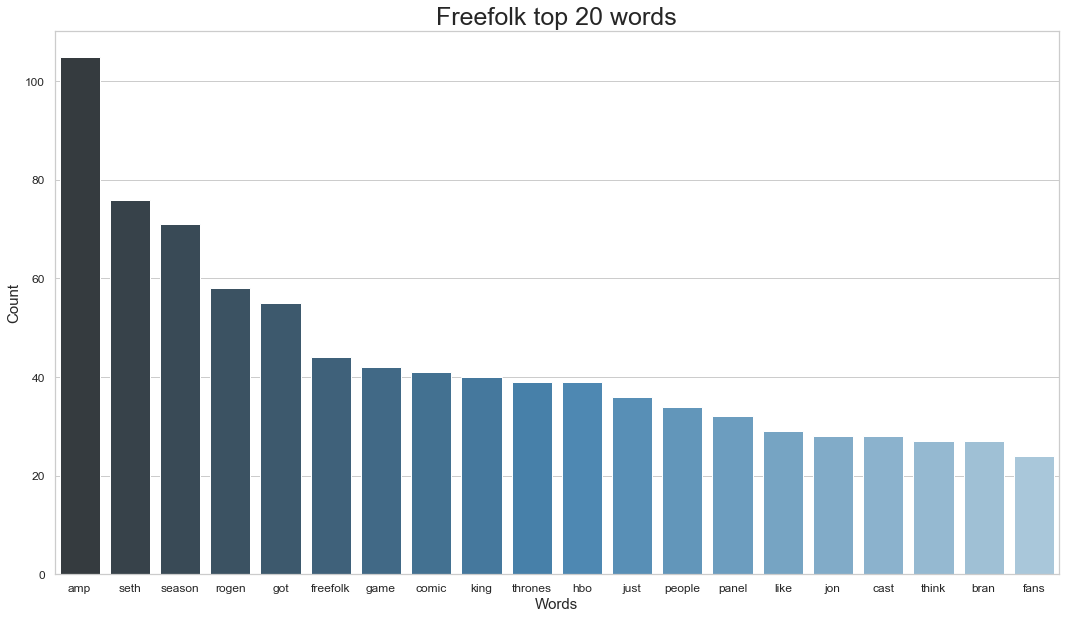

In [364]:
#visualization of most common words in freefolk
free_words = pd.DataFrame(word_counts.sort_values(ascending = False).head(20), columns=['count'])
plt.figure(figsize=(18,10))
sns.barplot(free_words.index, 'count', data=free_words, palette='Blues_d')
plt.title('Freefolk top 20 words', fontsize=25)
plt.xlabel('Words', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.tick_params(labelsize=12)

#### `pureasoiaf`

In [365]:
# Setting the vectorizer just like we would set a model
cvec = CountVectorizer()

# Fitting the vectorizer on our training data
cvec.fit(pure_select_df['title'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [366]:
# Lets check the length of our data that is in a vectorized state
print('# of features: {}'.format(len(cvec.get_feature_names())))

# of features: 2334


In [367]:
# Lets use the stop_words argument to remove words like "and, the, a"
cvec = CountVectorizer(stop_words='english')

# Fit our vectorizer using our train data
cvec.fit(pure_select_df['title'])

# and check out the length of the vectorized data after
print('# of features without stop words: {}'.format(len(cvec.get_feature_names())))

# of features without stop words: 2129


In [368]:
# Transforming using our fitted cvec.
# And converting the result to a DataFrame.
pure_title = pd.DataFrame(cvec.transform(pure_select_df['title']).todense(),
                       columns=cvec.get_feature_names())

In [369]:
# Which words appear the most in pure?
word_counts = pure_title.sum(axis=0)
print("Most common words in pureasoiaf")
word_counts.sort_values(ascending = False).head(20)

Most common words in pureasoiaf


spoilers    140
asoiaf       59
blood        46
amp          44
think        43
jon          41
did          41
just         40
books        35
read         35
does         33
adwd         32
chapter      32
twow         31
tyrion       30
westeros     28
time         26
question     26
favorite     26
series       25
dtype: int64

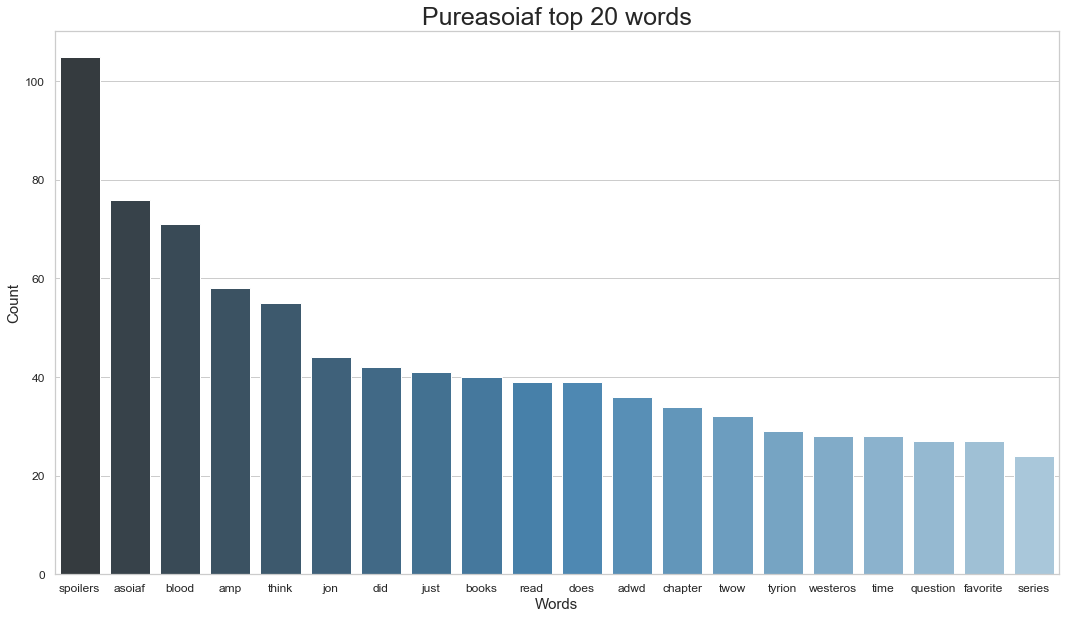

In [370]:
#visualization of most common words in pure
pure_words = pd.DataFrame(word_counts.sort_values(ascending = False).head(20), columns=['count'])
plt.figure(figsize=(18,10))
sns.barplot(pure_words.index, 'count', data=free_words, palette='Blues_d')
plt.title('Pureasoiaf top 20 words', fontsize=25)
plt.xlabel('Words', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.tick_params(labelsize=12)

### Combining data from both subreddits

In [371]:
all_df = pd.concat([pure_select_df,free_select_df])
all_df.shape

(1977, 3)

In [372]:
all_df['subreddit'].value_counts()

freefolk      992
pureasoiaf    985
Name: subreddit, dtype: int64

### Convert `subreddit` into binary values

In [373]:
all_df['subreddit'] = all_df['subreddit'].map(dict(pureasoiaf=1, freefolk=0))
all_df['subreddit'].value_counts()

0    992
1    985
Name: subreddit, dtype: int64

### Run initial model

In [374]:
X = all_df['title']
y = all_df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#### Baseline 

In [375]:
985/(985+992)

0.49822964087000504

Since there are 985 `pureasoiaf` posts out of a total of 1977 posts, we have a baseline slightly under 0.5.

#### CountVectorizer, Naive Bayes

In [376]:
# Setting the vectorizer just like we would set a model
cvec = CountVectorizer()

# Fitting the vectorizer on our training data
cvec.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [377]:
X_train = pd.DataFrame(cvec.transform(X_train).todense(),
                       columns=cvec.get_feature_names())

In [378]:
X_test = pd.DataFrame(cvec.transform(X_test).todense(),
                       columns=cvec.get_feature_names())

In [379]:
nb = MultinomialNB()
nb.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [380]:
preds = nb.predict(X_test)

In [381]:
#define function for model performance
def performance(real,pred):
    print('Confusion matrix')
    print('\n')
    print(pd.DataFrame(confusion_matrix(real, pred), index=['Actual negative', 'Actual positive'], columns=['Predicted negative', 'Predicted positive']))
    tn, fp, fn, tp = confusion_matrix(real, pred).ravel()
    print('\n')
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp)
    print('\n')
    print('-'*60)
    print('\n')
    print('Classification report')
    print('\n')
    print(classification_report(real,pred))
    print('-'*60)
    print('\n')
    acc = accuracy_score(real,pred)
    print('Accuracy score: {}'.format(acc))

In [382]:
performance(y_test, preds)

Confusion matrix


                 Predicted negative  Predicted positive
Actual negative                 258                  40
Actual positive                  46                 250


True Negatives: 258
False Positives: 40
False Negatives: 46
True Positives: 250


------------------------------------------------------------


Classification report


              precision    recall  f1-score   support

           0       0.85      0.87      0.86       298
           1       0.86      0.84      0.85       296

   micro avg       0.86      0.86      0.86       594
   macro avg       0.86      0.86      0.86       594
weighted avg       0.86      0.86      0.86       594

------------------------------------------------------------


Accuracy score: 0.8552188552188552


Using just a simple CountVectorizer and default Naive Bayes multinominal model, we are able to achieve an 85% accuracy, with 69 out of 594 posts classified wrongly - 46 `pureasoiaf` posts were classified erroneously and 40 `freefolk` posts were classified wrongly. This give us a good foundation to continue improving our predictions. 

### Further data preparation

#### Removing punctuation and capitalization

In [383]:
#lowercase words and strip punctuation except for apostrophe and dash
all_df['title_low'] = all_df['title'].map(lambda x: ''.join([y for y in list(x.lower()) if y in string.ascii_lowercase+" -'"]))
#strip dash as well, dash was not stripped in previous step as that would join word inappropriately eg: well-known to wellknown
all_df['title_low'] = all_df['title_low'].map(lambda x: x.replace('-',' '))

In [384]:
all_df.head()

,name,title,subreddit,title_low
0,t3_4g83fj,[No Spoilers] A Fair Warning. (ALL USERS PLEASE READ BEFORE POSTING),1,no spoilers a fair warning all users please read before posting
1,t3_cgc2aa,(Spoilers ADWD) This gave me all kinds of goosebumps,1,spoilers adwd this gave me all kinds of goosebumps
2,t3_cgad70,Why does Harrenhal have a Weirwood?,1,why does harrenhal have a weirwood
3,t3_cg1g6c,Does Stevron's death threaten the stability of house Frey.,1,does stevron's death threaten the stability of house frey
4,t3_cg21lz,Where was Tyrion before he arrived at Winterfell with Robert's Caravan?,1,where was tyrion before he arrived at winterfell with robert's caravan


## Modelling

### Function for modelling

Let's create a function that can loop combinations of vectorizers and models to determine the most effective combination and best hyperparameters. 

In [385]:
#make a function for modelling
#define X, y, and parameters of vectorizer and model outside function

def predictor(vec_name_list, vectorizer_list, model_name_list, model_list, vec_params_list, model_params_list, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    scores_list = [] #stores all scores and params generated
    for i, model in enumerate(model_list): #loop to cycle through all models
        for j, vectorizer in enumerate(vectorizer_list): #loop to cycle through all vectorizer
            
            results = {} #stores scores and params for one model-vectorizer combination
            
            print("Evaluation of {} and {}".format(model, vectorizer))
            print('\n')
            pipe = Pipeline([#pipeline for vectorizer and model
            (vec_name_list[j], vectorizer(stop_words='english')), #j to match vectorizer being used, use stop words
            (model_name_list[i], model()),#i to match model being used
            ])
            
            results['model'] = model_name_list[i] #storing the features of this model-vec combination
            results['vectorizer'] = vec_name_list[j]
            
            params = {**vec_params_list[j], **model_params_list[i]} #combine params for this model-vec combination
    
            gridsearch = GridSearchCV(#gridsearch to determine best params for vectorizer
            pipe,
            params,
            cv=5,
            verbose=1,
            n_jobs=2,
            return_train_score=False)

            gridsearch.fit(X_train,y_train)
    
            print("Best CV score: %0.3f" % gridsearch.best_score_) #CV score based on best params
            
            results['cv'] = gridsearch.best_score_ #storing best CV score for this run
            
            print("Best parameters set:")
            best_parameters = gridsearch.best_estimator_.get_params()
            for param_name in sorted(params.keys()):
                print("\t%s: %r" % (param_name, best_parameters[param_name]))
                results['{}'.format(param_name)] = best_parameters[param_name]
            print('\n')#create space between results
            print('-'*60)
            print('\n')
    
            preds = gridsearch.best_estimator_.predict(X_test) #predict based on best estimator from gridsearch

            #below is same code as performance function, but repeated here so that tn, fp, etc can be stored in results
            print('Confusion matrix')
            print('\n')
            print(pd.DataFrame(confusion_matrix(y_test, preds), index=['Actual negative', 'Actual positive'], columns=['Predicted negative', 'Predicted positive']))
            tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
            print('\n')
            print("True Negatives: %s" % tn)
            print("False Positives: %s" % fp)
            print("False Negatives: %s" % fn)
            print("True Positives: %s" % tp)
            print('\n')
            print('-'*60)
            print('\n')
            print('Classification report')
            print('\n')
            print(classification_report(y_test, preds))
            print('-'*60)
            print('\n')
            acc = accuracy_score(y_test, preds)
            print('Accuracy score: {}'.format(acc))
            print('\n')
            print('='*60)
            print('='*60)
            print('\n')
            
            results['true_neg'] = tn #storing test predictions 
            results['false_pos'] = fp
            results['false_neg'] = fn
            results['true_pos'] = tp
            results['accuracy'] = acc
            
            scores_list.append(results) #storing all results of this vec-model combi to list of all combi results
    
    df = pd.DataFrame(scores_list) #make dataframe to see results of all combinations ran
    cols = df.columns.tolist() #make a list of all the columns in df
    col1 = ['model', 'vectorizer', 'accuracy', 'true_pos', 'false_pos', 'true_neg', 'false_neg',
            'cv', 'cvec__max_features', 'tvec__max_features'] #all columns that we want at start of dataframe
    col2 = [col for col in cols if col not in col1] #columns of model hyperparams, will change according to how many models and hyperparams
    df = df[col1+col2] #order dataframe columns in the way we want to see them
    
    return df #return dataframe to see results of all combinations ran

### Combination of vectorizers and models

We will use the following vectorizers:
- `CountVectorizer`
- `TfidfVectorizer`

And the following models:
- `MultinomialNB`
- `KNeighborsClassifier`
- `LogisticRegression`

In [388]:
X = all_df['title_low']
y = all_df['subreddit']


vec_name_list = [
    'cvec',
    'tvec'
]

vectorizer_list = [
    CountVectorizer,
    TfidfVectorizer
]

model_name_list = [
    'nb',
    'knn',
    'rfc',
    'lr'
]

model_list = [
    MultinomialNB,
    KNeighborsClassifier,
    RandomForestClassifier,
    LogisticRegression
]

vec_params_list = [
    {'cvec__max_features': range(100,2400,100)},
    {'tvec__max_features': range(100,2400,100)}
]

nb_params = {
    'nb__alpha': np.linspace(0,1,num=11)
}

knn_params = {
    'knn__n_neighbors': range(1,50,10),
    'knn__metric': ['euclidean','manhattan']
}

rfc_params = {
    'rfc__n_estimators': range(50,100,10),
    'rfc__criterion': ['gini','entropy']
}

lr_params = {
    'lr__penalty': ['l1', 'l2'],
    'lr__C': np.logspace(-4, 0, 40)
}

model_params_list = [
    nb_params,
    knn_params,
    rfc_params,
    lr_params
]

predictor(vec_name_list, vectorizer_list, model_name_list, model_list, vec_params_list, model_params_list, X, y)

Evaluation of <class 'sklearn.naive_bayes.MultinomialNB'> and <class 'sklearn.feature_extraction.text.CountVectorizer'>


Fitting 5 folds for each of 253 candidates, totalling 1265 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 190 tasks      | elapsed:    6.3s
[Parallel(n_jobs=2)]: Done 1265 out of 1265 | elapsed:   24.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Best CV score: 0.835
Best parameters set:
	cvec__max_features: 1600
	nb__alpha: 0.5


------------------------------------------------------------


Confusion matrix


                 Predicted negative  Predicted positive
Actual negative                 247                  51
Actual positive                  47                 249


True Negatives: 247
False Positives: 51
False Negatives: 47
True Positives: 249


------------------------------------------------------------


Classification report


              precision    recall  f1-score   support

           0       0.84      0.83      0.83       298
           1       0.83      0.84      0.84       296

   micro avg       0.84      0.84      0.84       594
   macro avg       0.84      0.84      0.84       594
weighted avg       0.84      0.84      0.84       594

------------------------------------------------------------


Accuracy score: 0.835016835016835




Evaluation of <class 'sklearn.naive_bayes.MultinomialNB'> and <cl

[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed:   10.7s
[Parallel(n_jobs=2)]: Done 1265 out of 1265 | elapsed:   24.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Best CV score: 0.834
Best parameters set:
	nb__alpha: 1.0
	tvec__max_features: 1900


------------------------------------------------------------


Confusion matrix


                 Predicted negative  Predicted positive
Actual negative                 250                  48
Actual positive                  46                 250


True Negatives: 250
False Positives: 48
False Negatives: 46
True Positives: 250


------------------------------------------------------------


Classification report


              precision    recall  f1-score   support

           0       0.84      0.84      0.84       298
           1       0.84      0.84      0.84       296

   micro avg       0.84      0.84      0.84       594
   macro avg       0.84      0.84      0.84       594
weighted avg       0.84      0.84      0.84       594

------------------------------------------------------------


Accuracy score: 0.8417508417508418




Evaluation of <class 'sklearn.neighbors.classification.KNeighbor

[Parallel(n_jobs=2)]: Done 256 tasks      | elapsed:    9.0s
[Parallel(n_jobs=2)]: Done 1090 tasks      | elapsed:   55.4s
[Parallel(n_jobs=2)]: Done 1147 out of 1150 | elapsed:  1.0min remaining:    0.2s
[Parallel(n_jobs=2)]: Done 1150 out of 1150 | elapsed:  1.0min finished


Best CV score: 0.722
Best parameters set:
	cvec__max_features: 300
	knn__metric: 'manhattan'
	knn__n_neighbors: 1


------------------------------------------------------------


Confusion matrix


                 Predicted negative  Predicted positive
Actual negative                 242                  56
Actual positive                 122                 174


True Negatives: 242
False Positives: 56
False Negatives: 122
True Positives: 174


------------------------------------------------------------


Classification report


              precision    recall  f1-score   support

           0       0.66      0.81      0.73       298
           1       0.76      0.59      0.66       296

   micro avg       0.70      0.70      0.70       594
   macro avg       0.71      0.70      0.70       594
weighted avg       0.71      0.70      0.70       594

------------------------------------------------------------


Accuracy score: 0.7003367003367004




Evaluation of <class 'sklearn.nei

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 340 tasks      | elapsed:    8.8s
[Parallel(n_jobs=2)]: Done 904 tasks      | elapsed:   41.8s
[Parallel(n_jobs=2)]: Done 1150 out of 1150 | elapsed:  1.1min finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Best CV score: 0.759
Best parameters set:
	knn__metric: 'euclidean'
	knn__n_neighbors: 41
	tvec__max_features: 1900


------------------------------------------------------------


Confusion matrix


                 Predicted negative  Predicted positive
Actual negative                 285                  13
Actual positive                 139                 157


True Negatives: 285
False Positives: 13
False Negatives: 139
True Positives: 157


------------------------------------------------------------


Classification report


              precision    recall  f1-score   support

           0       0.67      0.96      0.79       298
           1       0.92      0.53      0.67       296

   micro avg       0.74      0.74      0.74       594
   macro avg       0.80      0.74      0.73       594
weighted avg       0.80      0.74      0.73       594

------------------------------------------------------------


Accuracy score: 0.7441077441077442




Evaluation of <class 'sklearn.e

[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    8.4s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   44.9s
[Parallel(n_jobs=2)]: Done 888 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done 1150 out of 1150 | elapsed:  2.9min finished


Best CV score: 0.805
Best parameters set:
	cvec__max_features: 1600
	rfc__criterion: 'entropy'
	rfc__n_estimators: 70


------------------------------------------------------------


Confusion matrix


                 Predicted negative  Predicted positive
Actual negative                 257                  41
Actual positive                  77                 219


True Negatives: 257
False Positives: 41
False Negatives: 77
True Positives: 219


------------------------------------------------------------


Classification report


              precision    recall  f1-score   support

           0       0.77      0.86      0.81       298
           1       0.84      0.74      0.79       296

   micro avg       0.80      0.80      0.80       594
   macro avg       0.81      0.80      0.80       594
weighted avg       0.81      0.80      0.80       594

------------------------------------------------------------


Accuracy score: 0.8013468013468014




Evaluation of <class 'sklearn.

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    9.9s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   51.7s
[Parallel(n_jobs=2)]: Done 888 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done 1150 out of 1150 | elapsed:  3.0min finished


Best CV score: 0.814
Best parameters set:
	rfc__criterion: 'gini'
	rfc__n_estimators: 60
	tvec__max_features: 1700


------------------------------------------------------------


Confusion matrix


                 Predicted negative  Predicted positive
Actual negative                 254                  44
Actual positive                  61                 235


True Negatives: 254
False Positives: 44
False Negatives: 61
True Positives: 235


------------------------------------------------------------


Classification report


              precision    recall  f1-score   support

           0       0.81      0.85      0.83       298
           1       0.84      0.79      0.82       296

   micro avg       0.82      0.82      0.82       594
   macro avg       0.82      0.82      0.82       594
weighted avg       0.82      0.82      0.82       594

------------------------------------------------------------


Accuracy score: 0.8232323232323232




Evaluation of <class 'sklearn.lin

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 225 tasks      | elapsed:    5.1s
[Parallel(n_jobs=2)]: Done 1125 tasks      | elapsed:   23.7s
[Parallel(n_jobs=2)]: Done 2625 tasks      | elapsed:   51.5s
[Parallel(n_jobs=2)]: Done 4725 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 7425 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done 9200 out of 9200 | elapsed:  2.9min finished
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Best CV score: 0.827
Best parameters set:
	cvec__max_features: 1800
	lr__C: 0.008886238162743407
	lr__penalty: 'l2'


------------------------------------------------------------


Confusion matrix


                 Predicted negative  Predicted positive
Actual negative                 259                  39
Actual positive                  61                 235


True Negatives: 259
False Positives: 39
False Negatives: 61
True Positives: 235


------------------------------------------------------------


Classification report


              precision    recall  f1-score   support

           0       0.81      0.87      0.84       298
           1       0.86      0.79      0.82       296

   micro avg       0.83      0.83      0.83       594
   macro avg       0.83      0.83      0.83       594
weighted avg       0.83      0.83      0.83       594

------------------------------------------------------------


Accuracy score: 0.8316498316498316




Evaluation of <class 'sklearn.li

[Parallel(n_jobs=2)]: Done 419 tasks      | elapsed:   11.8s
[Parallel(n_jobs=2)]: Done 1169 tasks      | elapsed:   35.8s
[Parallel(n_jobs=2)]: Done 2419 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done 4169 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 6419 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done 9169 tasks      | elapsed:  3.1min


Best CV score: 0.825
Best parameters set:
	lr__C: 0.30702906297578497
	lr__penalty: 'l2'
	tvec__max_features: 800


------------------------------------------------------------


Confusion matrix


                 Predicted negative  Predicted positive
Actual negative                 262                  36
Actual positive                  61                 235


True Negatives: 262
False Positives: 36
False Negatives: 61
True Positives: 235


------------------------------------------------------------


Classification report


              precision    recall  f1-score   support

           0       0.81      0.88      0.84       298
           1       0.87      0.79      0.83       296

   micro avg       0.84      0.84      0.84       594
   macro avg       0.84      0.84      0.84       594
weighted avg       0.84      0.84      0.84       594

------------------------------------------------------------


Accuracy score: 0.8367003367003367






[Parallel(n_jobs=2)]: Done 9200 out of 9200 | elapsed:  3.1min finished
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,model,vectorizer,accuracy,true_pos,false_pos,true_neg,false_neg,cv,cvec__max_features,tvec__max_features,knn__metric,knn__n_neighbors,lr__C,lr__penalty,nb__alpha,rfc__criterion,rfc__n_estimators
0,nb,cvec,0.835017,249,51,247,47,0.835141,1600.0,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN
1,nb,tvec,0.841751,250,48,250,46,0.833695,NaN,1900.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN
2,knn,cvec,0.700337,174,56,242,122,0.722343,300.0,NaN,manhattan,1.0,NaN,NaN,NaN,NaN,NaN
3,knn,tvec,0.744108,157,13,285,139,0.759219,NaN,1900.0,euclidean,41.0,NaN,NaN,NaN,NaN,NaN
4,rfc,cvec,0.801347,219,41,257,77,0.804772,1600.0,NaN,NaN,NaN,NaN,NaN,NaN,entropy,70.0
5,rfc,tvec,0.823232,235,44,254,61,0.814172,NaN,1700.0,NaN,NaN,NaN,NaN,NaN,gini,60.0
6,lr,cvec,0.831650,235,39,259,61,0.827187,1800.0,NaN,NaN,NaN,0.008886,l2,NaN,NaN,NaN
7,lr,tvec,0.836700,235,36,262,61,0.825018,NaN,800.0,NaN,NaN,0.307029,l2,NaN,NaN,NaN


### Evaluation of vectorizer and model performance

Based on the results, the `KNeighborsClassifier` performed the worst, with about 70% when paired with `CountVectorizer` and 74% when paired with `TfidfVectorizer`. 

The `RandomForestClassifier` performed better with 80% accuracy.  

The `MultinomialNB` and `LogisticRegression` similarly, with about 83% accuracy. 

We will select the `LogisticRegression`-`TfidVectorizer` combination for interpretability.

## Logistic model analysis

### Fitting data to `TfidfVectorizer` and `LogisticRegresssion`

In [389]:
tvec = TfidfVectorizer(stop_words='english')
lr = LogisticRegression()

X = all_df['title_low']
y = all_df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [390]:
tvec.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [391]:
X_train = pd.DataFrame(tvec.transform(X_train).todense(), #transform to dense 
                       columns=tvec.get_feature_names())

X_test = pd.DataFrame(tvec.transform(X_test).todense(), #transform to dense
                       columns=tvec.get_feature_names())

In [392]:
lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

### `GridSearchCV` to determine best hyperparameters

In [393]:
lr_params = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-4, 0, 40)
}

lr_gridsearch = GridSearchCV(#gridsearch to determine best params for model
            lr,
            lr_params,
            cv=5,
            verbose=1,
            n_jobs=2,
            return_train_score=False)

lr_gridsearch.fit(X_train,y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 143 tasks      | elapsed:    3.5s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    9.2s finished
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([1.00000e-04, 1.26638e-04, 1.60372e-04, 2.03092e-04, 2.57191e-04,
       3.25702e-04, 4.12463e-04, 5.22335e-04, 6.61474e-04, 8.37678e-04,
       1.06082e-03, 1.34340e-03, 1.70125e-03, 2.15443e-03, 2.72833e-03,
       3.45511e-03, 4.37548e-03, 5.54102e-... 2.42446e-01, 3.07029e-01,
       3.88816e-01, 4.92388e-01, 6.23551e-01, 7.89652e-01, 1.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=None, verbose=1)

In [394]:
lr_gridsearch.best_params_

{'C': 0.49238826317067363, 'penalty': 'l2'}

### Predictions

In [395]:
preds = lr_gridsearch.best_estimator_.predict(X_test)

In [396]:
performance(y_test,preds)

Confusion matrix


                 Predicted negative  Predicted positive
Actual negative                 256                  46
Actual positive                  46                 246


True Negatives: 256
False Positives: 46
False Negatives: 46
True Positives: 246


------------------------------------------------------------


Classification report


              precision    recall  f1-score   support

           0       0.85      0.85      0.85       302
           1       0.84      0.84      0.84       292

   micro avg       0.85      0.85      0.85       594
   macro avg       0.85      0.85      0.85       594
weighted avg       0.85      0.85      0.85       594

------------------------------------------------------------


Accuracy score: 0.8451178451178452


### Analysis of coefficients

In [397]:
#create dataframe of features with their corresponding coefficient values
coef_df = pd.DataFrame({'feature':X_train.columns,'coef':lr_gridsearch.best_estimator_.coef_[0]})
coef_df.sort_values(by=['coef'], inplace=True, ascending=False)

#### Top 20 words that increase probability of `pureasoiaf`

In [398]:
coef_df.head(20)

,feature,coef
2398,spoilers,2.807107
144,asoiaf,1.752485
271,blood,1.368584
35,adwd,1.071625
2033,read,1.054774
2650,twow,1.030752
404,chapter,1.028346
2794,westeros,1.018879
909,favorite,0.949522
2003,question,0.890698


$$log odds = \log \left({p\over 1-p}\right) = \beta_0 + \beta_1x + \beta_2x + ... + \beta_nx$$

Words with positive coefficients increase the log odds of the response and thus increase the probability that the post will be classified as `pureasoiaf`.

#### Comparison with `asoiaf` most-common word list

We had compiled a list of words that are most common in `asoiaf`. Let us now compare that with the coefficient list. These words below are both the most common words in `asoiaf` and also most impactful in determining a prediction of `asoiaf`.

In [399]:
#code to match with most common words in asoiaf
coef_df.head(20)[coef_df.head(20)['feature'].isin(pure_words.index)]

,feature,coef
2398,spoilers,2.807107
144,asoiaf,1.752485
271,blood,1.368584
35,adwd,1.071625
2033,read,1.054774
2650,twow,1.030752
404,chapter,1.028346
2794,westeros,1.018879
909,favorite,0.949522
2003,question,0.890698


These words below are not in the most common word list in `asoiaf` but were impactful in determining a prediction of `asoiaf`.

In [400]:
#code to find words in coef_df that are not in most common words in asoiaf
coef_df.head(20)[~coef_df.head(20)['feature'].isin(pure_words.index)]

,feature,coef
1919,pov,0.846502
2035,reading,0.816354
2161,robert,0.811087
405,chapters,0.793013
407,characters,0.750060
2564,theories,0.740580
285,book,0.713520


The model was intelligent enough to pick out the words 'reading' and 'chapters' as important in predicting `asoiaf`, which is dedicated to books.

#### Top 20 words that increase probability of `freefolk`

In [401]:
coef_df.tail(20).sort_values(by=['coef'])

,feature,coef
596,dampd,-1.989704
2272,seth,-1.746720
2239,season,-1.694602
471,comic,-1.315877
2167,rogen,-1.179519
1061,got,-1.096001
2136,rfreefolk,-1.093450
1816,panel,-1.046346
1135,hbo,-1.006175
378,cast,-0.986344


$$log odds = \log \left({p\over 1-p}\right) = \beta_0 + \beta_1x + \beta_2x + ... + \beta_nx$$

Words with negative coefficients decrease the log odds of the response and thus decrease the probability that the post will be classified as `pureasoiaf`. In other words, increasing the probability that the post will be classified as `freefolk`.

#### Comparison with `freefolk` most-common word list

We had compiled a list of words that are most common in `freefolk`. Let us now compare that with the coefficient list. These words below are both the most common words in `freefolk` and also most impactful in determining a prediction of `freefolk`.

In [402]:
#code to match with most common words in freefolk
coef_df.tail(20)[coef_df.tail(20)['feature'].isin(free_words.index)]

,feature,coef
990,freefolk,-0.791301
899,fans,-0.906309
378,cast,-0.986344
1135,hbo,-1.006175
1816,panel,-1.046346
1061,got,-1.096001
2167,rogen,-1.179519
471,comic,-1.315877
2239,season,-1.694602
2272,seth,-1.746720


These words below are not in the most common word list in `freefolk` but were impactful in determining a prediction of `freefolk`.

In [403]:
#code to negate match with most common words in freefolk
coef_df.tail(20)[~coef_df.tail(20)['feature'].isin(free_words.index)]

,feature,coef
278,bobby,-0.679596
1129,hate,-0.682949
804,ending,-0.705078
1407,kneelers,-0.765795
242,better,-0.797948
894,fan,-0.799553
2235,sdcc,-0.811520
1959,promised,-0.874149
2136,rfreefolk,-1.093450
596,dampd,-1.989704


Interestingly, the model was able to correctly assign a significantly negative coefficient to 'dampd', which is 'd&d', the initials of the oft-discussed pair of writers behind the TV series. Naturally, they don't appear in `pureasoiaf` at all as that subreddit is dedicated to the books. 

Text(0, 0.5, 'Words')

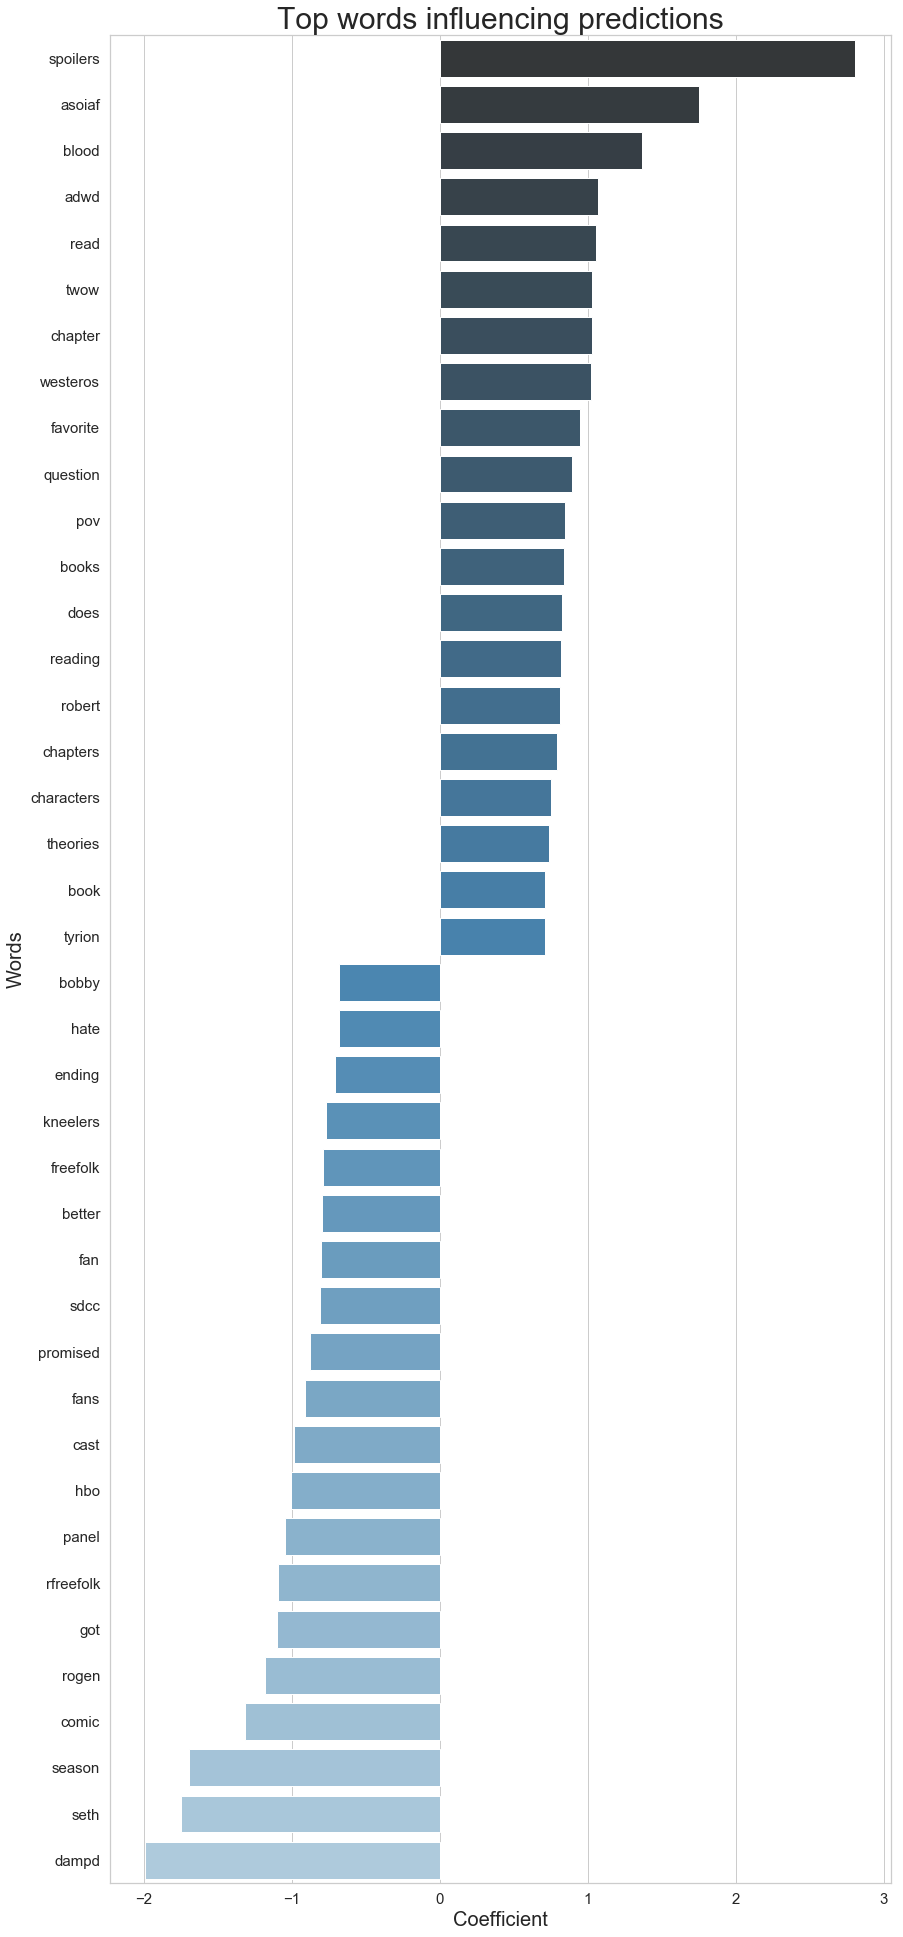

In [404]:
#visualize the top 20 words determining asoiaf and top 20 words determining freefolk
top_coef_df = pd.concat([coef_df.head(20), coef_df.tail(20)])
sns.set(style='whitegrid',rc={"figure.figsize": (14, 34)})
sns.barplot(y='feature',x='coef', data=top_coef_df, palette='Blues_d')
plt.title('Top words influencing predictions', fontsize=30)
plt.tick_params(labelsize=15)
plt.xlabel('Coefficient', fontsize=20)
plt.ylabel('Words', fontsize=20)

### Misclassified posts analysis

Redo the `train_test_split` to get unvectorized posts.

In [405]:
X = all_df['title_low']
y = all_df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [406]:
test_df = pd.concat([pd.DataFrame(X_test),pd.DataFrame(y_test)],axis=1)#combine X_test, y_test
test_df = test_df.reset_index() #reset index so that can join predictions

In [407]:
test_df = pd.concat([test_df,pd.DataFrame(preds,columns=['prediction'])],axis=1) #combine with predictions
test_df.head()

,index,title_low,subreddit,prediction
0,842,finally got to watching the last watch furdik was speaking some truth,0,0
1,904,the first is way bigger and angrier,0,0
2,678,if the dany chapter at the end of a dance with dragons didnt happen what would the state of this sub be,1,1
3,351,going through the world of ice and fire and this isn't making much sense to me,1,1
4,120,kneelers in a nutshell,0,0


Check which posts were predicted wrongly.

In [408]:
misclass_df = test_df[test_df['subreddit'] != test_df['prediction']] #subreddit doesnt match prediction
misclass_df.head()

,index,title_low,subreddit,prediction
6,70,want to do an unpopular predictions thread,1,0
8,56,cyvasse,1,0
10,555,direwolves hate tyrion why,1,0
22,840,im confused,0,1
25,331,when show euron killed balon in his first scene i thought he was going to be badass,0,1


In [409]:
false_pos_df = misclass_df[misclass_df['prediction'] == 1]
false_neg_df = misclass_df[misclass_df['prediction'] == 0]
print(false_pos_df.shape[0]) # to check if number matches false pos 
print(false_neg_df.shape[0]) #to check if number matches false neg

46
46


#### False positives

In [410]:
pd.options.display.max_colwidth =140
false_pos_df

,index,title_low,subreddit,prediction
22,840,im confused,0,1
25,331,when show euron killed balon in his first scene i thought he was going to be badass,0,1
33,345,just take the beating dudes,0,1
44,333,a khal who cannot ride is no khal,0,1
69,805,cant wait till grrm dies and we get this masterpiece,0,1
78,629,i just can't help myself,0,1
86,338,jon at his unsullied trial how the hell did grey worm know he killed dany if drogon flew of with her body,0,1
117,662,adopted children and children with terrible parents when the writers endorse genetic determinism,0,1
127,752,and then crying immediately after,0,1
149,193,i've came up with another solution to jon's heritage issue if dany wouldn't have liked to marry or kill him she could have named him a m...,0,1


False positives are broadly in two categories:
- Posts that use character names (Euron, Targaryen) and places (Westeros, Blackwater). These terms are likelier to be in the `pureasoiaf` subreddit that discusses intricate plot developments.
- Short posts with fewer than five words. Perhaps there was too little information for the model to form an informed prediction. 

#### False negatives

In [411]:
false_neg_df

,index,title_low,subreddit,prediction
6,70,want to do an unpopular predictions thread,1,0
8,56,cyvasse,1,0
10,555,direwolves hate tyrion why,1,0
30,651,is this how you picture this fight,1,0
31,211,will arya ever become no one,1,0
37,111,maynard plumms true identity,1,0
45,316,mindblowing,1,0
48,426,in terms of the ending how much do you actually care who sits the throne,1,0
68,69,winter is coming,1,0
94,196,how do you think daenerys' timeline would have been changed if khal drogo had not died,1,0


It is more difficult to discern patterns in the false negatives. While there are posts that are too short to give useful information, other posts appear quite easy to categorize as `asoiaf` posts, at least to the human eye. For example, there are a few posts mentioning books.  

## Conclusion

### Findings

- After experimenting with several models, we achieved 84.5% accuracy in predicting which subreddit a post came from using the `LogisticRegression`-`TfidfVectorizer` combination. 
- This model was chosen for its interpretability and we found that the model was intelligent enough to pick certain words that had high predictive power even though they are not the most common words in their subreddits.

### Limitations

- Many of the posts, especially in `freefolk`, were memes and did not contain text in the post's body for analysis. We could rely only on the titles of the posts. 

### Further exploration

- Move beyond the Reddit API, which allows just 1,000 posts, and collect larger datasets to see if that can improve performance.
- Compare more Game of Thrones-related subreddits to see if results hold up across different fanbases. 
- Collect another 1,000 posts each from subreddits during a different time period to see if results differ. This is particularly the case for `freefolk`, which was very much influenced by the San Diego Comic Convention and Emmy Awards nomination during the time of data collection. 